<a href="https://colab.research.google.com/github/MerkulovDaniil/intro_opt/blob/master/notebooks/intro_opt_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi task learning

[Multi-Task Learning as Multi-Objective Optimization](https://arxiv.org/pdf/1810.04650.pdf)

![](https://pbs.twimg.com/media/DAZmPvpUIAAcQ5b.jpg)

In [78]:
!pip install pymoo

     |████████████████████████████████| 3.7MB 5.1MB/s 
     |████████████████████████████████| 245kB 30.2MB/s 
  Created wheel for pymoo: filename=pymoo-0.4.2.1-cp36-cp36m-linux_x86_64.whl size=1344733 sha256=425b1c87818ec5d7a09ba61e381d56ba7bb5ead34e8b968eab780b8631f37f87
  Stored in directory: /root/.cache/pip/wheels/24/1a/15/c95ef6c978305899c8b374fd3a36dd494a46a63b2b32c6c5c5
Successfully built pymoo


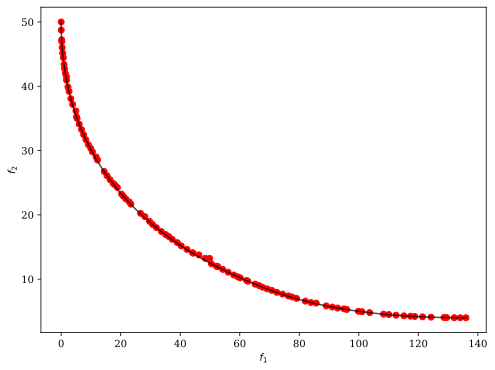

In [85]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("bnh")

algorithm = NSGA2(pop_size=100)

res = minimize(problem,
               algorithm,
               ('n_gen', 200),
               seed=1,
               verbose=False)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, color="red")
plot.show()

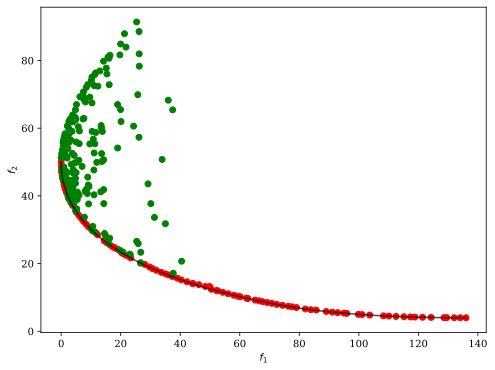

In [106]:
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, color="red")
for i in range(200):
    x = np.random.randn(2)
    plot.add(np.array(problem.evaluate(x)[0]), color="green")
plot.show()

# Portfolio optimization
[source](https://www.cvxpy.org/examples/index.html)

![](https://memepedia.ru/wp-content/uploads/2019/06/stonks-template.png)

### Portfolio allocation vector

In this example we show how to do portfolio optimization using CVXPY.
We begin with the basic definitions.
In portfolio optimization we have some amount of money to invest in any of $n$ different assets. 
We choose what fraction $w_i$ of our money to invest in each asset $i$, $i=1, \ldots, n$.

We call $w\in {\bf R}^n$ the *portfolio allocation vector*.
We of course have the constraint that ${\mathbf 1}^T w =1$.
The allocation $w_i<0$ means a *short position* in asset $i$, or that we borrow shares to sell now that we must replace later.
The allocation $w \geq 0$ is a *long only* portfolio.
The quantity
$$ \|w \|_1 = {\mathbf 1}^T w_+ + {\mathbf 1}^T w_- $$
is known as *leverage*.

### Asset returns

We will only model investments held for one period. The initial prices are $p_i > 0$. The end of period prices are $p_i^+ >0$. The asset (fractional) returns are $r_i = (p_i^+-p_i)/p_i$. The porfolio (fractional) return is $R = r^Tw$.

A common model is that $r$ is a random variable with mean ${\bf E}r = \mu$ and covariance ${\bf E{(r-\mu)(r-\mu)^T}} = \Sigma$.
It follows that $R$ is a random variable with ${\bf E}R = \mu^T w$ and ${\bf var}(R) = w^T\Sigma w$.
${\bf E}R$ is the (mean) *return* of the portfolio. ${\bf var}(R)$ is the *risk* of the portfolio.
(Risk is also sometimes given as ${\bf std}(R) = \sqrt{{\bf var}(R)}$.)

Portfolio optimization has two competing objectives: high return and low risk.

### Classical (Markowitz) portfolio optimization

Classical (Markowitz) portfolio optimization solves the optimization problem

\begin{array}{ll} \mbox{maximize} & \mu^T w - \gamma w^T\Sigma w\\
\mbox{subject to} & {\bf 1}^T w = 1, \quad w \in {\cal W},
\end{array}

where $w \in {\bf R}^n$ is the optimization variable, $\cal W$ is a set of allowed portfolios (e.g., ${\cal W} = {\bf R}_+^n$ for a long only portfolio), and $\gamma >0$ is the *risk aversion parameter*.

The objective $\mu^Tw - \gamma w^T\Sigma w$ is the *risk-adjusted return*. Varying $\gamma$ gives the optimal *risk-return trade-off*. 
We can get the same risk-return trade-off by fixing return and minimizing risk.

### Example

In the following code we compute and plot the optimal risk-return trade-off for $10$ assets, restricting ourselves to a long only portfolio.

In [1]:
# Generate data for long only portfolio optimization.
import numpy as np
np.random.seed(1)
n = 10
mu = np.abs(np.random.randn(n, 1))
Sigma = np.random.randn(n, n)
Sigma = Sigma.T.dot(Sigma)

In [2]:
# Long only portfolio optimization.
import cvxpy as cp


w = cp.Variable(n)
gamma = cp.Parameter(nonneg=True)
ret = mu.T*w 
risk = cp.quad_form(w, Sigma)
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                w >= 0])

In [3]:
# Compute trade-off curve.
SAMPLES = 100
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    risk_data[i] = cp.sqrt(risk).value
    ret_data[i] = ret.value

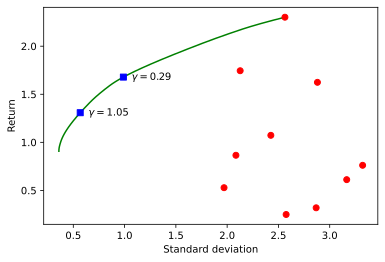

In [9]:
# Plot long only trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [29, 40]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+.08, ret_data[marker]-.03))
for i in range(n):
    plt.plot(cp.sqrt(Sigma[i,i]).value, mu[i], 'ro')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

We plot below the return distributions for the two risk aversion values marked on the trade-off curve.
Notice that the probability of a loss is near 0 for the low risk value and far above 0 for the high risk value.

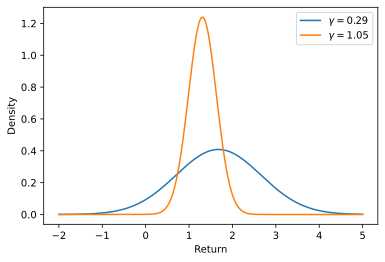

In [10]:
# Plot return distributions for two points on the trade-off curve.
import scipy.stats as spstats


plt.figure()
for midx, idx in enumerate(markers_on):
    gamma.value = gamma_vals[idx]
    prob.solve()
    x = np.linspace(-2, 5, 1000)
    plt.plot(x, spstats.norm.pdf(x, ret.value, risk.value), label=r"$\gamma = %.2f$" % gamma.value)

plt.xlabel('Return')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

### Portfolio constraints

There are many other possible portfolio constraints besides the long only constraint. With no constraint (${\cal W} = {\bf R}^n$), the optimization problem has a simple analytical solution. We will look in detail at a *leverage limit*, or the constraint that $\|w \|_1 \leq L^\mathrm{max}$.


Another interesting constraint is the *market neutral* constraint $m^T \Sigma w =0$, where $m_i$ is the capitalization of asset $i$.
$M = m^Tr$ is the *market return*, and $m^T \Sigma w = {\bf cov}(M,R)$.
The market neutral constraint ensures that the portfolio return is uncorrelated with the market return.

### Example

In the following code we compute and plot optimal risk-return trade-off curves for leverage limits of 1, 2, and 4.
Notice that more leverage increases returns and allows greater risk.

In [11]:
# Portfolio optimization with leverage limit.
Lmax = cp.Parameter()
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                cp.norm(w, 1) <= Lmax])

In [12]:
# Compute trade-off curve for each leverage limit.
L_vals = [1, 2, 4]
SAMPLES = 100
risk_data = np.zeros((len(L_vals), SAMPLES))
ret_data = np.zeros((len(L_vals), SAMPLES))
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
w_vals = []
for k, L_val in enumerate(L_vals):
    for i in range(SAMPLES):
        Lmax.value = L_val
        gamma.value = gamma_vals[i]
        prob.solve(solver=cp.SCS)
        risk_data[k, i] = cp.sqrt(risk).value
        ret_data[k, i] = ret.value

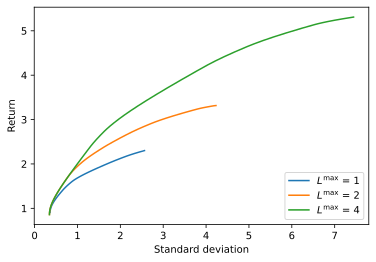

In [13]:
# Plot trade-off curves for each leverage limit.
for idx, L_val in enumerate(L_vals):
    plt.plot(risk_data[idx,:], ret_data[idx,:], label=r"$L^{\max}$ = %d" % L_val)
for w_val in w_vals:
    w.value = w_val
    plt.plot(cp.sqrt(risk).value, ret.value, 'bs')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.legend(loc='lower right')
plt.show()

We next examine the points on each trade-off curve where $w^T\Sigma w = 2$.
We plot the amount of each asset held in each portfolio as bar graphs. (Negative holdings indicate a short position.)
Notice that some assets are held in a long position for the low leverage portfolio but in a short position in the higher leverage portfolios. 

In [14]:
# Portfolio optimization with a leverage limit and a bound on risk.
prob = cp.Problem(cp.Maximize(ret), 
              [cp.sum(w) == 1, 
               cp.norm(w, 1) <= Lmax,
               risk <= 2])

In [15]:
# Compute solution for different leverage limits.
for k, L_val in enumerate(L_vals):
    Lmax.value = L_val
    prob.solve()
    w_vals.append( w.value )

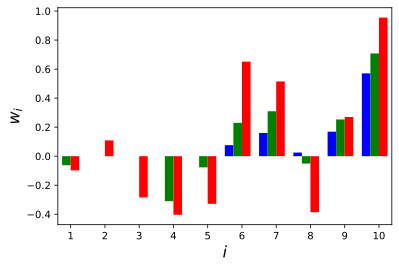

In [16]:
# Plot bar graph of holdings for different leverage limits.
colors = ['b', 'g', 'r']
indices = np.argsort(mu.flatten())
for idx, L_val in enumerate(L_vals):
     plt.bar(np.arange(1,n+1) + 0.25*idx - 0.375, w_vals[idx][indices], color=colors[idx], 
             label=r"$L^{\max}$ = %d" % L_val, width = 0.25)
plt.ylabel(r"$w_i$", fontsize=16)
plt.xlabel(r"$i$", fontsize=16)
plt.xlim([1-0.375, 10+.375])
plt.xticks(np.arange(1,n+1))
plt.show()

### Variations

There are many more variations of classical portfolio optimization. We might require that $\mu^T w \geq R^\mathrm{min}$ and minimize $w^T \Sigma w$ or $\|\Sigma ^{1/2} w\|_2$.
We could include the (broker) cost of short positions as the penalty $s^T (w)_-$ for some $s \geq 0$.
We could include transaction costs (from a previous portfolio $w^\mathrm{prev}$) as the penalty

$$
\kappa ^T |w-w^\mathrm{prev}|^\eta, \quad
\kappa \geq 0.
$$


Common values of $\eta$ are $\eta =1, ~ 3/2, ~2$.


### Factor covariance model

A particularly common and useful variation is to model the covariance matrix $\Sigma$ as a factor model

$$
\Sigma  =  F \tilde \Sigma F^T + D,
$$

where  $F \in {\bf R}^{n \times k}$, $k \ll n$ is the *factor loading matrix*. $k$ is the number of factors (or sectors) (typically 10s). $F_{ij}$ is the loading of asset $i$ to factor $j$.
$D$ is a diagonal matrix; $D_{ii}>0$ is the *idiosyncratic risk*. $\tilde \Sigma > 0$ is the *factor covariance matrix*.

$F^Tw \in {\bf R}^k$ gives the portfolio *factor exposures*. A portfolio is *factor $j$ neutral* if $(F^Tw)_j=0$.


### Portfolio optimization with factor covariance model

Using the factor covariance model, we frame the portfolio optimization problem as 

\begin{array}{ll} \mbox{maximize} & \mu^T w - \gamma \left(f^T \tilde \Sigma f  + w^TDw \right) \\
\mbox{subject to} & {\bf 1}^T w = 1, \quad f=F^Tw\\
& w \in {\cal W}, \quad f \in {\cal F},
\end{array}

where the variables are the allocations $w \in {\bf R}^n$ and factor exposures $f\in {\bf R}^k$ and $\cal F$ gives the factor exposure constraints.

Using the factor covariance model in the optimization problem has a computational advantage. The solve time is $O(nk^2)$ versus $O(n^3)$ for the standard problem.

### Example

In the following code we generate and solve a portfolio optimization problem with 50 factors and 3000 assets.
We set the leverage limit $=2$ and $\gamma=0.1$.

We solve the problem both with the covariance given as a single matrix and as a factor model.
Using CVXPY with the OSQP solver running in a single thread, the solve time was 173.30 seconds for the single matrix formulation and 0.85 seconds for the factor model formulation.
We collected the timings on a MacBook Air with an Intel Core i7 processor.

In [17]:
# Generate data for factor model.
n = 3000
m = 50
np.random.seed(1)
mu = np.abs(np.random.randn(n, 1))
Sigma_tilde = np.random.randn(m, m)
Sigma_tilde = Sigma_tilde.T.dot(Sigma_tilde)
D = np.diag(np.random.uniform(0, 0.9, size=n))
F = np.random.randn(n, m)

In [18]:
# Factor model portfolio optimization.
w = cp.Variable(n)
f = F.T*w
gamma = cp.Parameter(nonneg=True)
Lmax = cp.Parameter()
ret = mu.T*w 
risk = cp.quad_form(f, Sigma_tilde) + cp.quad_form(w, D)
prob_factor = cp.Problem(cp.Maximize(ret - gamma*risk), 
                     [cp.sum(w) == 1, 
                      cp.norm(w, 1) <= Lmax])

# Solve the factor model problem.
Lmax.value = 2
gamma.value = 0.1
prob_factor.solve(verbose=True)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 6050, constraints m = 6052
          nnz(P) + nnz(A) = 172325
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -2.1359e+03   7.63e+00   3.73e+02   1.00e-01   7.33e-02s
 200  -4.1946e+00   1.59e-03   7.86e-03   3.60e-01   4.82e-01s
 400  -4.6288e+00   3.02e-04   6.01e-04 

4.606413081938858

In [21]:
# Standard portfolio optimization with data from factor model.
risk = cp.quad_form(w, F.dot(Sigma_tilde).dot(F.T) + D)
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                cp.norm(w, 1) <= Lmax])

# Uncomment to solve the problem.
# WARNING: this will take many minutes to run.
prob.solve(verbose=True, max_iter=30000)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 6000, constraints m = 6002
          nnz(P) + nnz(A) = 4519500
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 30000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.1774e+04   2.65e+02   1.51e+04   1.00e-01   7.97e+00s
 200  -4.1080e+02   2.42e-01   8.86e-04   1.00e-01   1.10e+01s
 400  -1.9413e+02   1.13e-01   2.51e-04

4.64886481797565

In [22]:
print('Factor model solve time = {}'.format(prob_factor.solver_stats.solve_time))
print('Single model solve time = {}'.format(prob.solver_stats.solve_time))

Factor model solve time = 3.0333686589999997
Single model solve time = 483.077024319


## Как с деньгами обстоит вопрос
What about real data?

![](https://pbs.twimg.com/media/Ef-YalfXYAAUDaf.jpg)

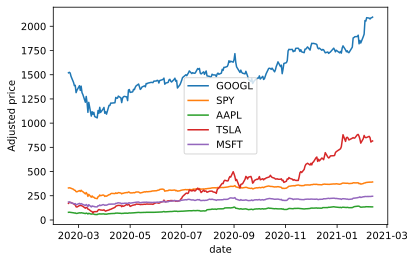

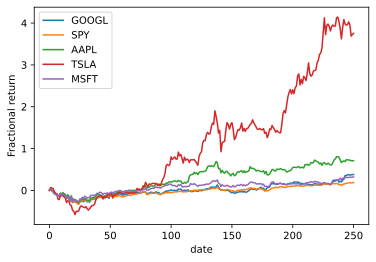

In [44]:
from pandas_datareader import data as web
import datetime
import matplotlib.pyplot as plt

stocks = ['GOOGL', 'SPY', 'AAPL', 'TSLA', 'MSFT']

start_date = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%m-%d-%Y")
df = web.DataReader(stocks, data_source='yahoo', start=start_date)

# Adjusted price
for stock in stocks:
    plt.plot(df['Adj Close'][stock], label=stock)
plt.xlabel('date')
plt.ylabel('Adjusted price')
plt.legend()
plt.show()

# Fractional return
frac_return = {}
for stock in stocks:
    frac_return[stock] = [(price - df['Adj Close'][stock][0])/df['Adj Close'][stock][0] for price in df['Adj Close'][stock]]
    plt.plot(frac_return[stock], label=stock)
plt.xlabel('date')
plt.ylabel('Fractional return')
plt.legend()
plt.show()

In [47]:
# Calculating mean and covariance of fractional return
# number of stocks
N = len(frac_return)

# number of historical values per stock
M = len(frac_return[stocks[0]])

mu = np.zeros(N)
Sigma = np.zeros((N,N))
Prices = np.zeros((M,N))

for i_asset, (stock, return_array) in enumerate(frac_return.items()):
    mu[i_asset] = np.array(return_array).mean()
    Prices[:, i_asset] = return_array

Sigma = 1/N*(Prices - mu).T @ (Prices - mu)

In [49]:
# Long only portfolio optimization.
import cvxpy as cp


w = cp.Variable(N)
gamma = cp.Parameter(nonneg=True)
ret = mu.T@w 
risk = cp.quad_form(w, Sigma)
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                w >= 0])

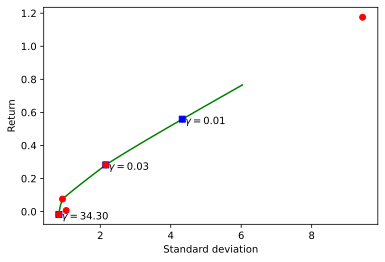

In [59]:
# Compute trade-off curve.
SAMPLES = 100
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    risk_data[i] = cp.sqrt(risk).value
    ret_data[i] = ret.value

# Plot long only trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [3, 10, 70]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+.08, ret_data[marker]-.03))
for i in range(N):
    plt.plot(cp.sqrt(Sigma[i,i]).value, mu[i], 'ro')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

In [76]:
# Long only portfolio optimization.
import cvxpy as cp


w = cp.Variable(N)
gamma = 10
ret = mu.T@w 
risk = cp.quad_form(w, Sigma)
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                w >= 0])
prob.solve(verbose=True)

print(f'{[(stock, x) for stock, x in zip(stocks, w.value)]}')

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 5, constraints m = 6
          nnz(P) + nnz(A) = 25
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -2.0945e-03   1.00e+00   1.36e+03   1.00e-01   2.08e-04s
  50   6.8270e+00   5.75e-06   1.96e-04   8.09e-01   5.78e-04s
plsh   6.8271e+00   2.14e-22   0.00e+00   --------

In [67]:
[(stock, x) for (stock, x) in zip(stocks, w.value)]

[('GOOGL', -1.2310333739669261e-23),
 ('SPY', 1.0705162474990867e-22),
 ('AAPL', 0.5995001807644814),
 ('TSLA', -1.5763444272763734e-23),
 ('MSFT', 0.4004998192355186)]

## Materials
* [Portfolio Optimization Algo Trading colab notebook](https://colab.research.google.com/drive/1nN5yOB3ZFXKxq4y9WwzCVTV1i_BVpfAD#scrollTo=5hQgHpjM87r4)
* [Multi objective portfolio optimization](https://colab.research.google.com/github/Hvass-Labs/FinanceOps/blob/master/04_Multi-Objective_Portfolio_Optimization.ipynb#scrollTo=84UWnvT9iA4p)

# Alternating minimization
[source](https://ee227c.github.io/code/lecture19.html)



In [108]:
import numpy as np


def gradient_descent(init, steps, grad, proj=lambda x: x, num_to_keep=None):
    """Projected gradient descent.
    
    Parameters
    ----------
        initial : array
            starting point
        steps : list of floats
            step size schedule for the algorithm
        grad : function
            mapping arrays to arrays of same shape
        proj : function, optional
            mapping arrays to arrays of same shape
        num_to_keep : integer, optional
            number of points to keep
        
    Returns
    -------
        List of points computed by projected gradient descent. Length of the
        list is determined by `num_to_keep`.
    """
    xs = [init]
    for step in steps:
        xs.append(proj(xs[-1] - step * grad(xs[-1])))
        if num_to_keep:
          xs = xs[-num_to_keep:]
    return xs


def conditional_gradient(initial, steps, oracle, num_to_keep=None):
    """Conditional gradient.
    
        Conditional grdient (Frank-Wolfe) for first-order optimization.
    
    Parameters:
    -----------
        initial: array,
            initial starting point
        steps: list of numbers,
            step size schedule
        oracle: function,
            mapping points to points, implements linear optimization 
            oracle for the objective.
    
    Returns:
    --------
        List of points computed by the algorithm.
    """
    xs = [initial]
    for step in steps:
        xs.append(xs[-1] + step*(oracle(xs[-1])-xs[-1]))
        if num_to_keep:
          xs = xs[-num_to_keep:]
    return xs


def gss(f, a, b, tol=1e-5):
    """Golden section search.
        Source: https://en.wikipedia.org/wiki/Golden-section_search
    Find the minimum of f on [a,b]
    Parameters:
    -----------
        f: a strictly unimodal function on [a,b]
        a: lower interval boundary
        b: uper interval boundary
    Returns:
    --------
        Point in the interval [a, b]
    """
    gr = 1.6180339887498949
    c = b - (b - a) / gr
    d = a + (b - a) / gr 
    while abs(c - d) > tol:
        if f(c) < f(d):
            b = d
        else:
            a = c
        # we recompute both c and d here to avoid loss of precision 
        # which may lead to incorrect results or infinite loop
        c = b - (b - a) / gr
        d = a + (b - a) / gr
    return (b + a) / 2


def random_search(oracle, init, num_steps, line_search=gss):
    """Implements random search.
    Parameters:
    -----------
        oracle: Function.
        init: Point in domain of oracle.
        num_steps: Number of iterations.
        line_search: Line search method (defaults to golden section.)
    
    Returns:
    --------
        List of iterates.
    """
    
    iterates = [init]
    for _ in range(num_steps):
        d = np.random.normal(0, 100, init.shape)
        d /= np.linalg.norm(d)
        x = iterates[-1]
        eta = line_search(lambda step: oracle(x + step * d), -1, 1)
        iterates.append(x + eta * d)
    return iterates 

In [109]:
import numpy as np


def simplex_projection(vector):
    """Projection onto the unit simplex.
    
        Source: https://gist.github.com/daien/1272551
    Parameters:
    -----------
        vector: array  
            Vector to be projected onto simplex.
    Returns:
    --------
        Vector in the unit simplex
    """
    if np.sum(vector) <=1 and np.alltrue(vector >= 0):
        return vector 
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(vector)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, len(u)+1) > (cssv - 1))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = (cssv[rho] - 1) / (rho + 1.0)
    # compute the projection by thresholding v using theta
    return np.maximum(vector-theta, 0)


def nuclear_projection(matrix):
    """Projection onto nuclear norm unit ball.
    Parameters:
        matrix: two-dimensional array
            Matrix to be projected onto nuclear norm unit ball.
    Returns:
        Matrix in the unit ball of the nuclear norm.
    """
    U, s, V = np.linalg.svd(matrix, full_matrices=False)
    s = simplex_projection(s)
    return U.dot(np.diag(s).dot(V))

In [110]:

import matplotlib
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML


kwargs = {'linewidth' : 3.5}
font = {'weight' : 'normal', 'size'   : 24}


def error_plot(ys, yscale='log'):
    plt.figure(figsize=(8, 8))
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale(yscale)
    plt.plot(range(len(ys)), ys, **kwargs)
    

def convergence_plot(fs, gs):
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.title('Convergence in objective')    
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale('log')
    plt.plot(range(len(fs)), fs, **kwargs)
    plt.subplot(122)
    plt.title('Convergence in domain')    
    plt.xlabel('Step')
    plt.yscale('log')
    plt.plot(range(len(gs)), gs, **kwargs)
    plt.tight_layout()


def setup_layout():
    matplotlib.rc('font', **font)

In [111]:
%matplotlib inline

#import numpy as np
import autograd.numpy as np
from autograd import grad
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

np.random.seed(228)

setup_layout()

<a name="am"></a>

## Low-rank matrix factorization

In low-rank matrix factorization we're generally trying to solve an objective of the form

$$
\min_{\mathrm{rank}(M)\le k} f(M),
$$

where $f\colon\mathbb{R}^{m\times n}\to\mathbb{R}$ is a convex function. Note that the set of rank $k$ matrices forms a non-convex set.

In lecture 5, we saw that this problem can be attacked using the *nuclear norm relaxation* of the rank constraint. Projecting onto the unit ball of the nuclear norm was a costly operation that does not scale large matrices. We saw how to mitigate this problem using the Frank-Wolfe algorithm, in which the nuclear norm projection is replaced by a linear optimization step that is solved by the power method.

Here we'll see a natural approach to solve the non-convex formulation directly without any relaxation via *alternating minimization*.

### Alternating minimization

The idea behind alternating minimization is that a rank $k$ matrix $M$ can be written in factored form as $M=XY^\top,$ where $X\in\mathbb{R}^{m\times k}$ and $Y\in\mathbb{R}^{n\times k}$.

Given initial guesses $X_0,Y_0,$ we can then alternate between optimizing $X$ and optimizing $Y$ separately as follows:

For $t=1,\dots, T:$
* $X_t=\arg\min_{X} f(XY_{t-1}^\top)$
* $Y_t=\arg\min_{Y} f(X_t Y^\top)$

Since matrix multiplication is bilinear, the function $f(XY^\top)$ is convex in its argument $X$ and also convex in its argument $Y$.

In [119]:
def alternating_minimization(left, right, update_left, update_right,
                            num_updates):
    """Alternating minimization."""
    iterates = [(left, right)]
    for _ in range(num_updates):
        left = update_left(right)
        right = update_right(left)
        iterates.append((left, right))
    return iterates

Check out [this monograph](https://arxiv.org/abs/1712.07897) by Jain and Kar for a survey of convergence results for alternating minimization.

### Matrix completion

A common instance of this general problem is known as *matrix completion*. Here we have a partially observed matrix $m\times n$ matrix and we try to fill in its missing entries. This is generally impossible unless we make additional assumptions on the target matrix. A natural assumption is that the target matrix is close to low rank. In other words, the matrix is specified by far fewer than $mn$ parameters.

To set up some notation:
* We observe coordinates of an unknown matrix $A\in\mathbb{R}^{m\times n}$ specified by a set $\Omega.$
* We denote by $P_\Omega$ the coordinate projection of a matrix onto the set of entries in $\Omega.$
* We will denote by $\|\cdot\|_F$ the Frobenius norm.

The matrix completion objective can then be written as:

$$
\min_{X\in\mathbb{R}^{m\times k}, Y\in\mathbb{R}^{n\times k}}
\frac12\|P_{\Omega}(A-XY^\top)\|_F^2
$$

### Assumptions

To make the problem tractable, researchers rely on primarily two assumptions:

* Uniformly random samples: The entries of $\Omega$ are chosen independently at random.
* Incoherence: The entries of $A$ are "spread out" so that a random samples picks up a propertional share of $A$ with good probability. Formally, this can be achieved by assuming that the singular vectors of $A$ have small $\ell_\infty$-norm.

### Alternating updates for matrix completion

Here we'll compute the updates needed for alternating minimization via a naive direct solve in each row using the pseudoinverse. 

In other words, this approach takes advantage of the explicit form of $f$ as the Frobenius norm. While simple and slow when naively implemented, this approach, known as [Alternating Least Squares](https://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf) is popular because it is possible to create fairly efficient distributed versions of the algorithm.

Since both sides of the alternation are equivalent up to transposition, let's consider our problem for fixed $X$, solving for the least squares solution $Y$ in
$$
\min_{Y\in \mathbb{R}^{n\times k}}\frac{1}{2}\left\|P_{\Omega}(A-XY^\top)\right\|_F^2\,.
$$

Since the $i$-th row $\textbf{y}_i$ of $Y$ is the only component of $Y$ that appears in the $i$-th column of $P_{\Omega}(A-XY^\top)$, and the Frobenius norm is additive in matrix entries, we can optimize each row separately and combine them later to recover the solution to the joint problem over matrices $Y$; so fix $i\in[n]$ and consider
$$
\min_{\textbf{y}\in\mathbb{R}^k}\left\|\textbf{s}_i\times (\textbf{a}_i-X\textbf{y})\right\|_2^2\,,
$$
where $\textbf{a}_i$ is the $i$-th column vector of $A$ and $\textbf{s}_i$ is a binary vector corresponding to projection onto known entries $(\cdot ,i)\in \Omega$ (where above we use pointwise multiplication, but rewriting this as multiplication with a diagonal binary matrix we recover a cannonical least squares problem).

This means we need to solve $n$ $k$-dimensional-input $m$-dimensional-output least-squares problems. Since $\textbf{s}_i$ is binary, we can reduce the size of the output dimension of the least-squares problem by ignoring the entries that are zeroed out (reducing output dimension to $\left\|\textbf{s}_i\right\|_1$).

This approach is pretty slow when performed serially!. We could instead use any of the convex solvers we already saw. The advantage of a direct solve is that we have no additional hyperparameters to worry about. However, we can see that the independence of the $n$ subproblems would be amenable to a distributed implementation.

In [114]:
def update_right(A, S, X):
    """Update right factor for matrix completion objective."""
    m, n = A.shape
    _, k = X.shape
    Y = np.zeros((n, k))
    # For each row, solve a k-dimensional regression problem
    # only over the nonzero projection entries. Note that the
    # projection changes the least-squares matrix siX so we
    # cannot vectorize the outer loop.
    for i in range(n):
        si = S[:, i]
        sia = A[si, i]
        siX = X[si]
        Y[i,:] = np.linalg.lstsq(siX, sia)[0]
    return Y

def update_left(A, S, Y):
    return update_right(A.T, S.T, Y)

We can now instantiate the general algorithm for our problem.

In [115]:
def altmin(A, S, rank, num_updates):
    """Toy implementation of alternating minimization."""
    m, n = A.shape
    X = np.random.normal(0, 1, (m, rank))
    Y = np.random.normal(0, 1, (n, rank))
    return alternating_minimization(X, Y, 
                                    lambda Y: update_left(A, S, Y), 
                                    lambda X: update_right(A, S, X),
                                    num_updates)

Below is code to plot a matrix decomposition in a neat manner. Ignore this for now, unless you're really into matplotlib.

In [116]:
def plot_decomposition(A, U=None, V=None):
    """Plot matrix decomposition."""
    m, n = A.shape
    fig_height = 9
    fig_width = float(n)*fig_height/m
    
    cmap=plt.get_cmap('bwr')
    bounds=np.concatenate([np.linspace(-100,-4,1), np.linspace(-4,-0.005,114),
        np.linspace(-0.005,0.005,25), np.linspace(0.005,4,114),np.linspace(4,100,1)])
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure(figsize=(fig_width, fig_height))
    
    rects = [[0.05,0.15,0.8,0.8],[0.825,0.15,0.1,0.8],[0.05,0.05,0.8,0.1]]
    
    ims = []
    for (rect, mat) in zip(rects, [A, U, V]):
        if type(mat)==type(None):
            break
        ax = fig.add_axes(rect)
        ims.append(
            ax.imshow(mat, cmap=cmap,norm=norm,interpolation='none'))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.xaxis.set_tick_params(size=0)    
        ax.yaxis.set_tick_params(size=0)

    cbaxes = fig.add_axes([0.1, 0.01, 0.7, 0.05])
    plt.colorbar(ims[0], orientation='horizontal', cax=cbaxes)
    plt.show()

Let's see how alternating minimization works in a toy example.

In [117]:
def subsample(A, density):
    """Randomly zero out entries of the input matrix."""
    C = np.matrix.copy(A)
    B = np.random.uniform(0, 1, C.shape)
    C[B > density] = 0
    return C, B <= density    
    
def example1():
    """Run alternating minimization on subsample of rank 2 matrix."""

    A = np.zeros((40, 70))
    # Create rank 2 matrix with checkerboard pattern
    for i in range(0,40):
        for j in range(0,70):
            if divmod(i, 2)[1]==0:
                A[i,j] += -3.0
            if divmod(i, 2)[1]==1:
                A[i,j] += 3.0
            if divmod(j, 2)[1]==0:
                A[i,j] += 1.0
            if divmod(j, 2)[1]==1:
                A[i,j] += -1.0
    plot_decomposition(A)
    B, S = subsample(A, 0.25)
    plot_decomposition(B)
    results = altmin(A, S, 2, 10)
    for (U, V) in results:
        plot_decomposition(np.dot(U, V.T), U, V.T)        
    
    return

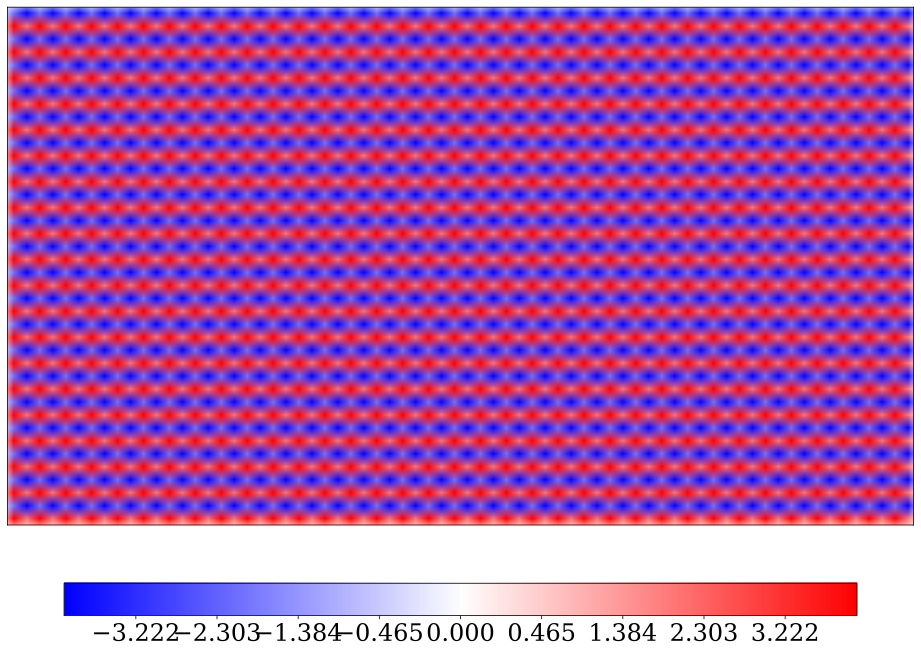

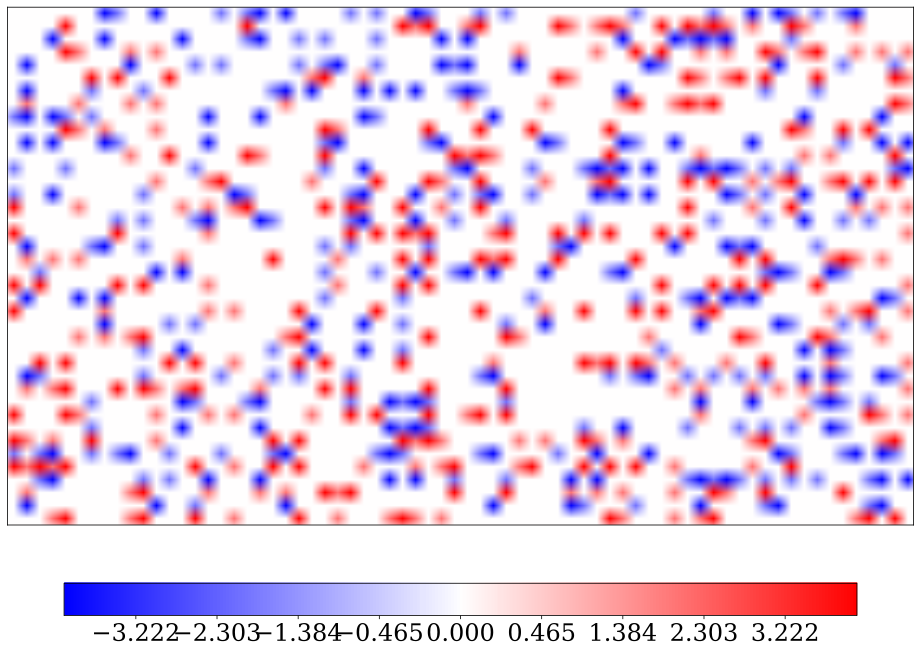

/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)


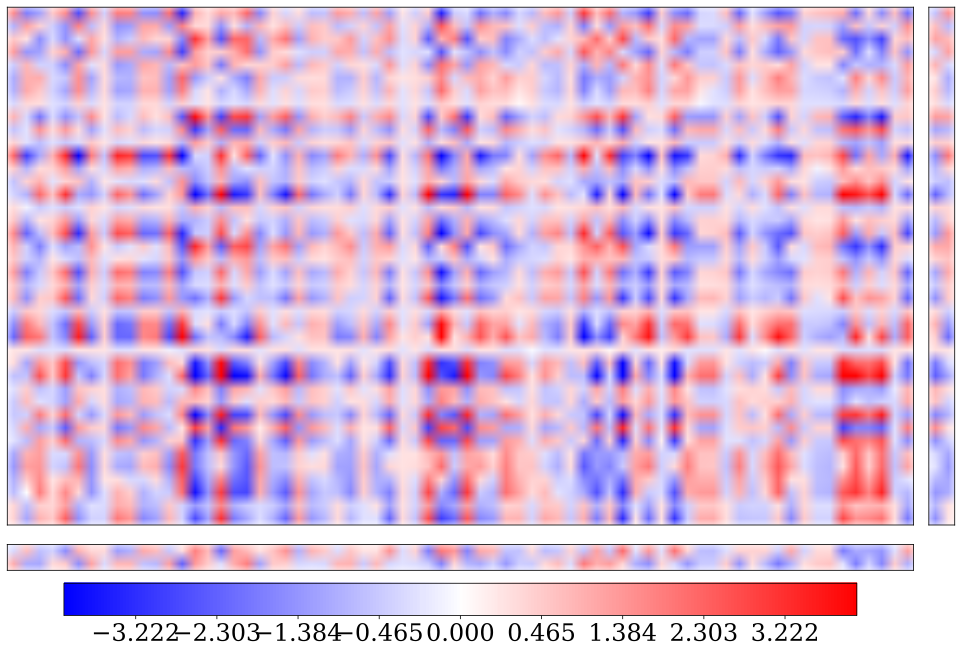

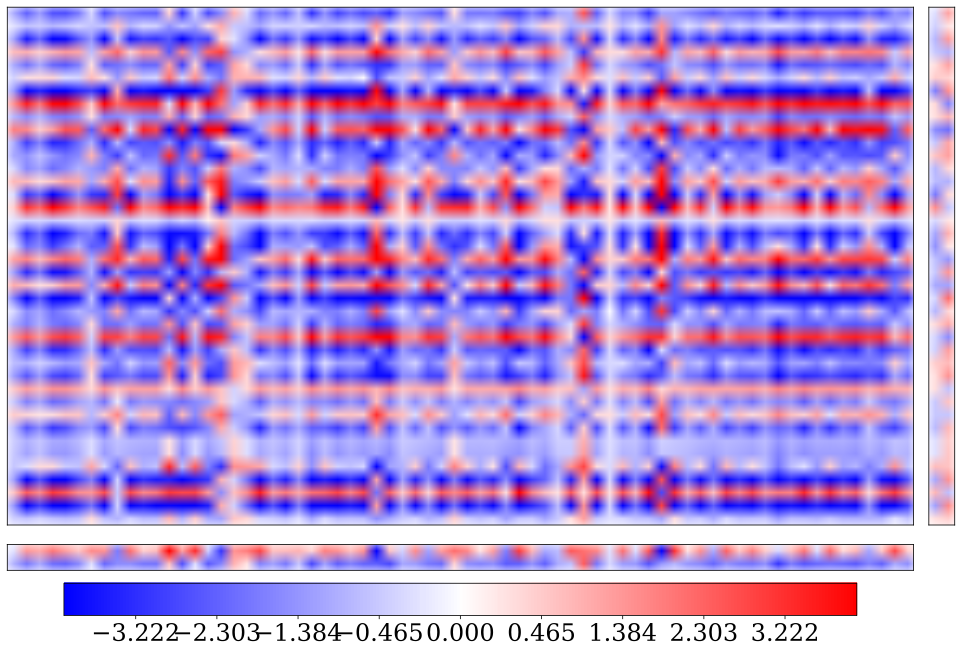

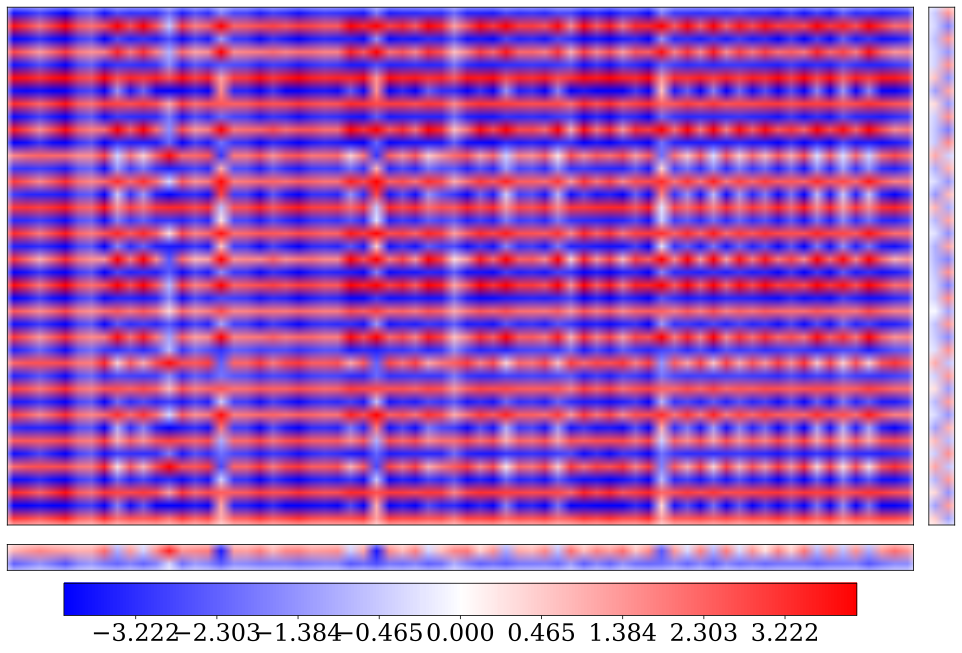

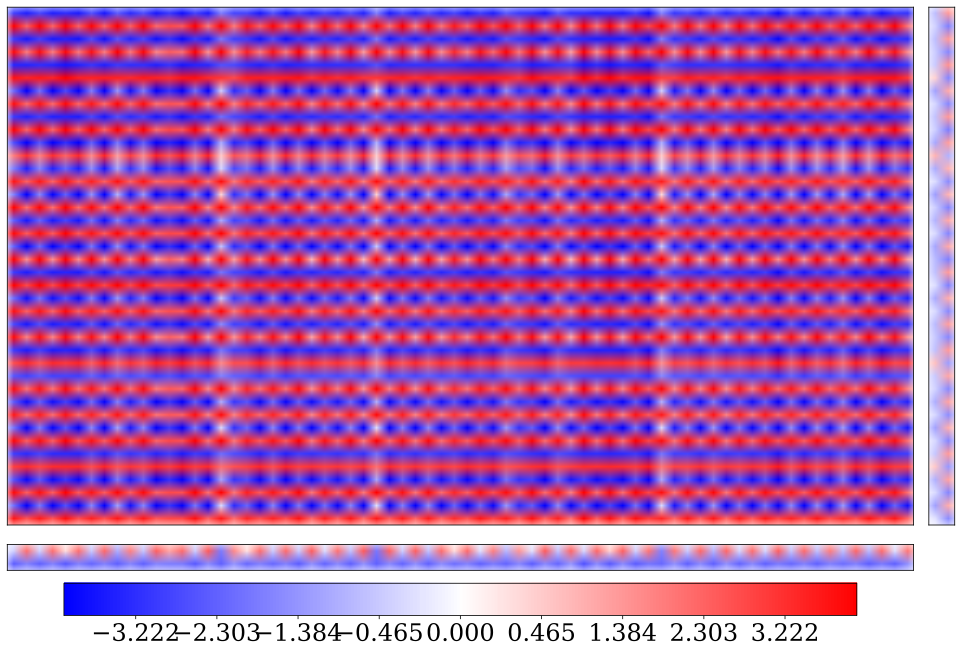

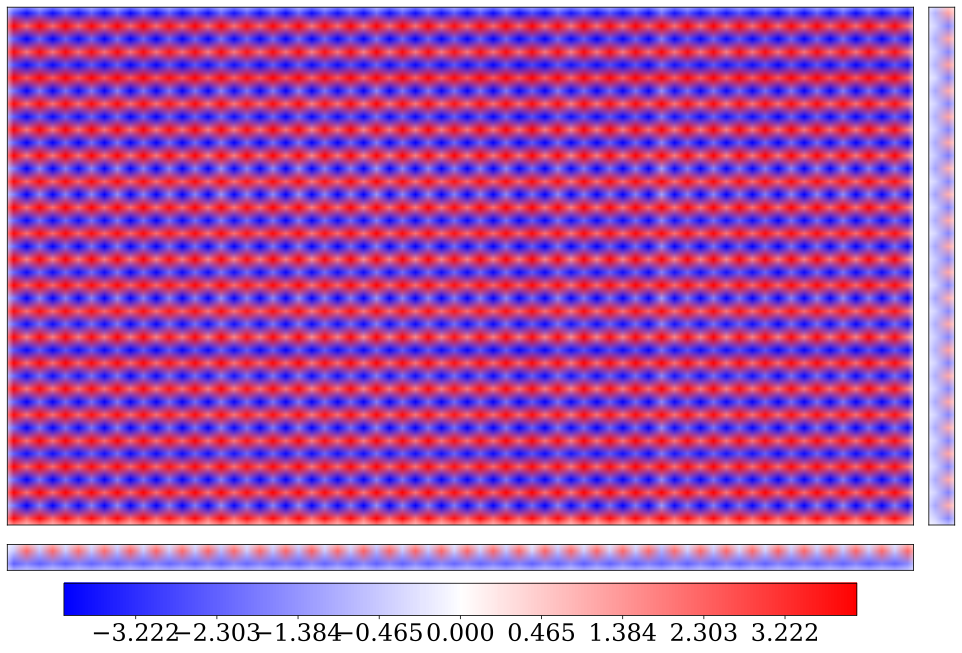

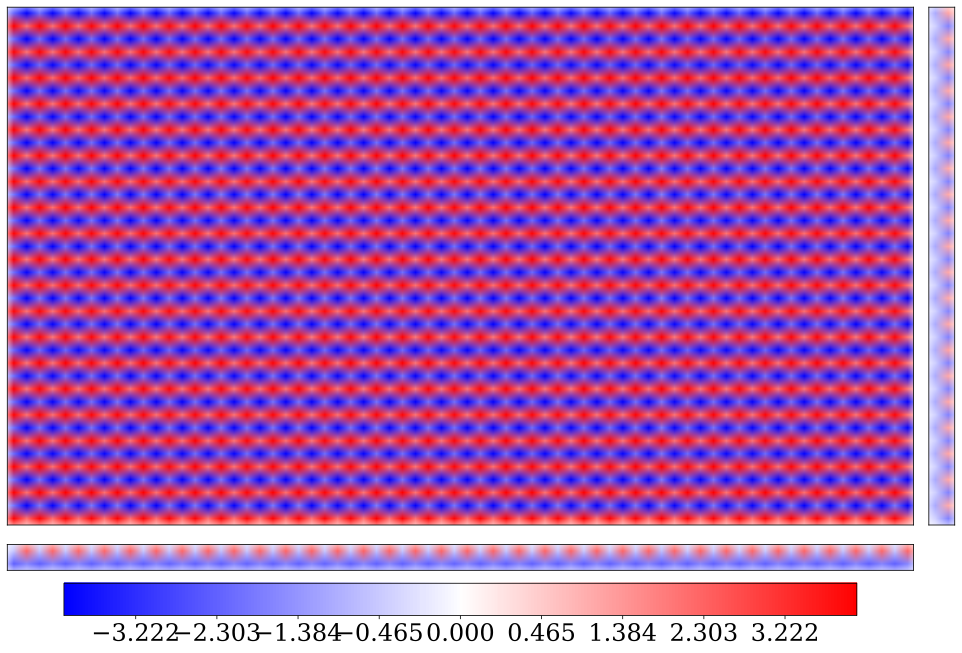

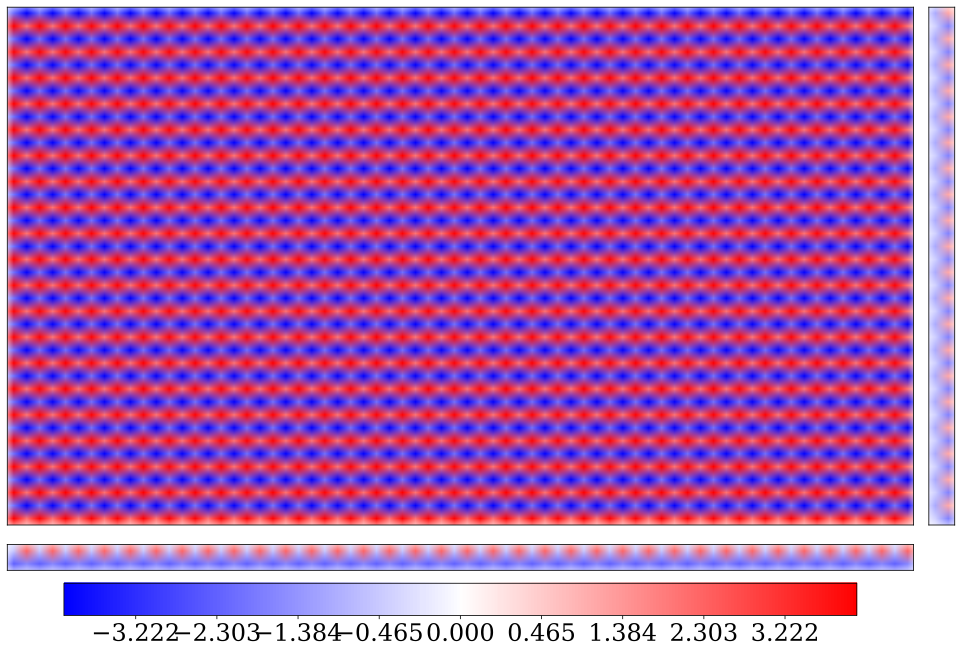

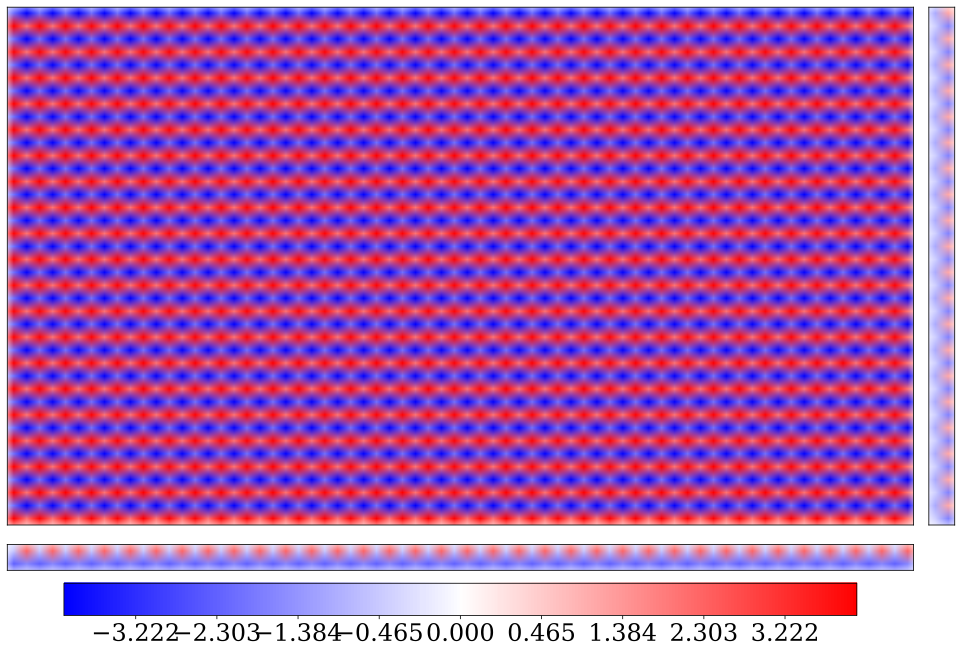

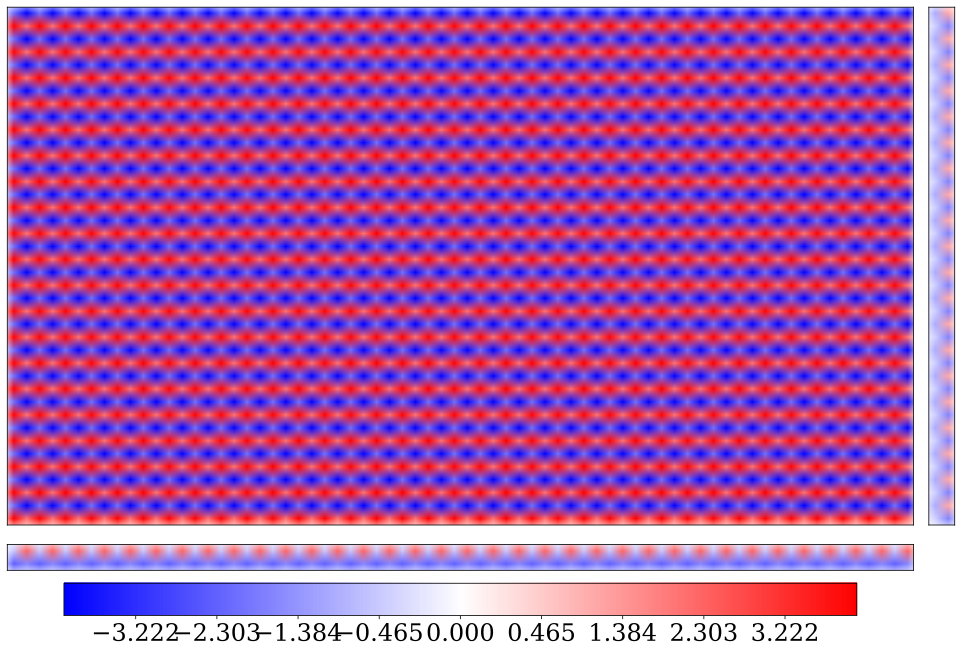

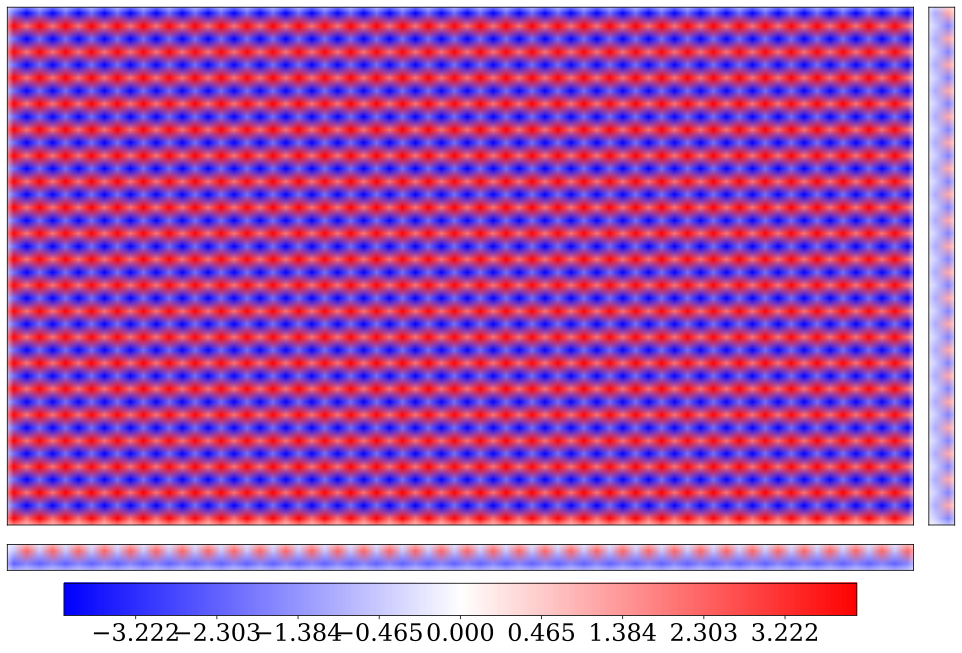

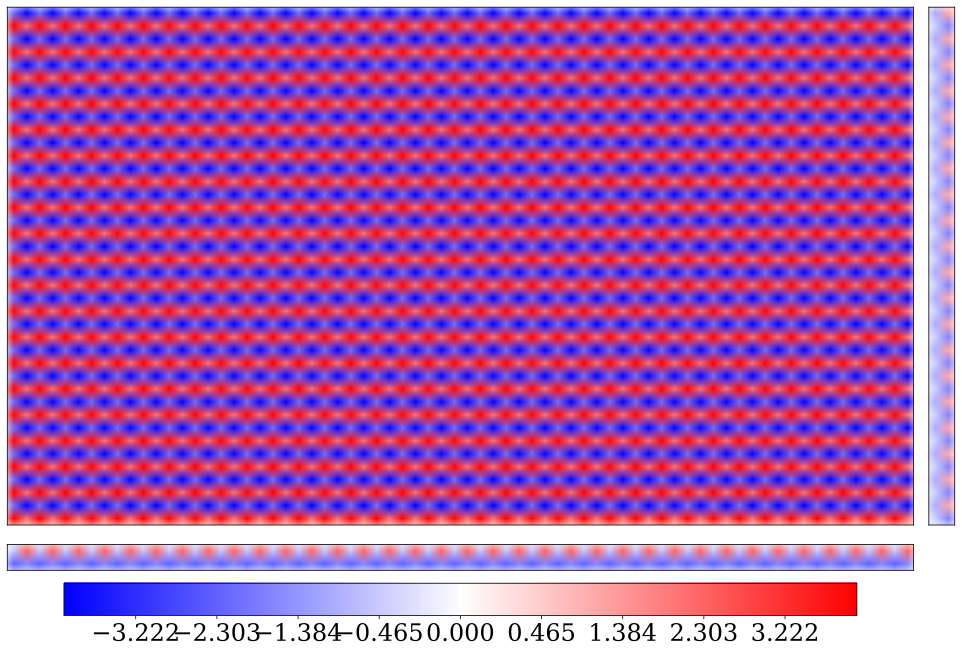

In [118]:
example1()

We see that after a few iterations, alternating minimization has found a good approximation. Restart this algorithm a few times to see that the convergence is affected strongly by the random initialization.

### Exercises

* Code up a more serious implementation that does not ever compute a full $m\times n$ matrix, but rather works with a given set of observed entries. Use stochastic gradient descent as a sub-routine for the updates.
* Do a running time analysis of the algorithm.

### Comparison with gradient descent and nuclear norm projection

Below is our example from Lecture 5.

In [120]:
n, k = 1000, 10
# random rank-10 matrix normalized to have nuclear norm 1
U = np.random.normal(0, 1, (n, k))
U = np.linalg.qr(U)[0]
L = np.diag(np.random.uniform(0, 1, k))
L /= np.sum(L)
A = U.dot(L.dot(U.T))
# pick which entries we observe uniformly at random
S = np.random.randint(0, 2, (n, n))
# multiply A by S coordinate-wise
# B = P_\Omega(A)
B = np.multiply(A, S)

def mc_objective(B, S, X):
    """Matrix completion objective."""
    # 0.5*\|P_\Omega(A-X)\|_F^2
    return 0.5 * np.linalg.norm(B-np.multiply(X, S), 'fro')**2

def mc_gradient(B, S, X):
    """Gradient of matrix completion objective."""
    return np.multiply(X, S) - B


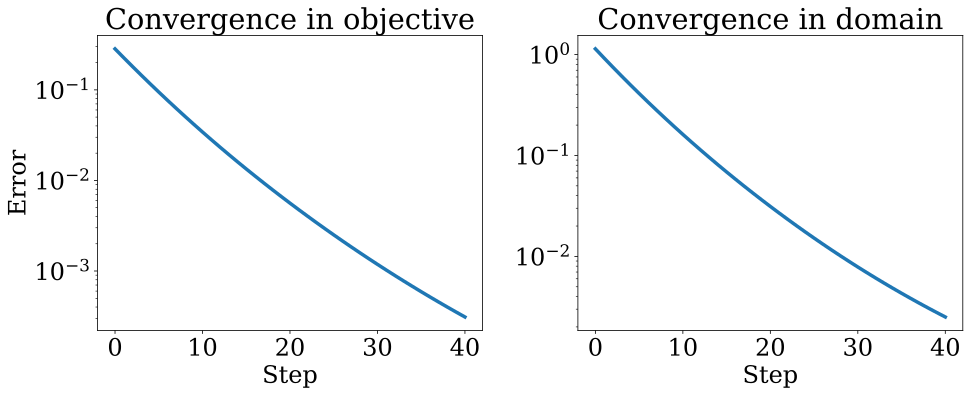

In [121]:
def example2():
    # start from random matrix of nuclear norm 1
    X0 = np.random.normal(0,1, (n,n))
    X0 = nuclear_projection(X0.dot(X0.T))
    objective = lambda X: mc_objective(B, S, X)
    gradient = lambda X: mc_gradient(B, S, X)
    Xs = gradient_descent(X0, [0.2]*40, gradient, nuclear_projection)

    convergence_plot([objective(X) for X in Xs],
                    [np.linalg.norm(A-X, 'fro')**2 for X in Xs])
    
example2()

The algorithm was pretty slow even on this tiny example.

Below we compare it with a variant of alternating minimization that makes a single gradient step in each update. There are numerous natural variants depending on which optimizer we choose. A popular method involves stochastic updates that use only a single entry.

In [ ]:
def mc_objective_factored(B, S, X, Y):
    """Matrix completion objective."""
    m, n = B.shape
    return 0.5 * np.linalg.norm(B-np.multiply(np.dot(X, Y.T), S))**2

def altmin_gd(rank, num_updates):
    """Toy implementation of alternating minimization."""
    m, n = A.shape
    X = np.linalg.qr(np.random.normal(0, 1, (n, k)))[0]
    Y = np.linalg.qr(np.random.normal(0, 1, (n, k)))[0]
    iterates = [(X, Y)]
    for i in range(num_updates):
        X = X - grad(lambda X: mc_objective_factored(B, S, X, Y))(X)
        Y = Y - grad(lambda Y: mc_objective_factored(B, S, X, Y))(Y)
        iterates.append((X, Y))
    return iterates

In [ ]:
results = altmin_gd(10, 1000)
obj_values = [mc_objective_factored(B, S, X, Y) for (X, Y) in results]
dom_values = [np.linalg.norm(A-X.dot(Y.T), 'fro')**2 for (X, Y) in results]
convergence_plot(obj_values, dom_values)

The convergence behavior is pretty peculiar. It rapidly converges to the quality of the all zeros solution and then slows down substantially.

In [ ]:
mc_objective(B, S, 0)

0.028210546968991758

## Tensor completion factorization

### Problem
Let us consider a problem of fitting tensor $T$ with the following rank $r$ CP decomposition:

$$
\|T - (A, B, C) \cdot I\|^2_F \to \min_{A \in \mathbb{R}^{I \times r}, B \in \mathbb{R}^{J \times r}, C \in \mathbb{R}^{K \times r}}
$$

In this manner we would like to calculate any entry of the tensor $T$ as a following sum of $r$ summands:

$$
T_{ijk} = \sum\limits_{p = 1}^r A_{ip} B_{jp} C_{kp}
$$

Schematic illustration of CP-decomposition:

![](https://raw.githubusercontent.com/MerkulovDaniil/optim/master/assets/Notebooks/cp_tensor.SVG)

This problem can be also formulated in a matrix form

$$
\|T_{JK \times I} - (B \odot C)A^\top\|^2_F \to \min_{A \in \mathbb{R}^{I \times r}, B \in \mathbb{R}^{J \times r}, C \in \mathbb{R}^{K \times r}}
$$

### Data

#### Random rank R CP tensor
We will construct tensor $T$ by randomly sampling entries of the factor matrices $A \in \mathbb{R}^{I \times r}, B \in \mathbb{R}^{J \times r}, C \in \mathbb{R}^{K \times r}$ from the standard normal distribution $\mathcal{N}(0, 1)$. Each column of the factor matrices is normalized to unit length, and the constructed tensor is denoted as

$$
T = (A, B, C) \cdot I + \mu \dfrac{\|(A, B, C) \cdot I\|_F}{\|N\|_F} N,
$$

where $N$ stands for the 3d Gaussian noise tensor and $\mu$ is a small signal-to-noise parameter.

### Alternating Least Squares (ALS) algorithm
The basic idea of ALS is to fix all the variables, except one and write down optimal solution, then repeat the same for all the variables.

**Input** Tensor $T$, stopping criteria $\varepsilon$, rank $r$

* Initialize $A^0, B^0, C^0$ as gaussian random matrices with $\mathcal{N}(0, 1)$ distribution, $\hat{T}^0 = (A^0,B^0,C^0) \cdot I$, $k = 0$

* **while** $\frac{\|\hat{T}^k - T\|_F}{\|T\|_F} \geq \varepsilon$:
    * $(B^\top)^{k+1} = (C^k \odot A^k)^\dagger \hat{T}^k_{KI \times J}$
    * $(C^\top)^{k+1} = (A^k \odot B^{k+1})^\dagger \hat{T}^k_{IJ \times K}$
    * $(A^\top)^{k+1} = (B^{k+1} \odot C^{k+1})^\dagger \hat{T}^k_{JK \times I}$
    * $\hat{T}^{k+1} = (A^{k+1},B^{k+1},C^{k+1}) \cdot I$
    * $k = k+1$

**Return** Tensor $\hat{T}^{k}$ with CP rank $r$ such that $\frac{\|\hat{T}^k - T\|_F}{\|T\|_F} < \varepsilon$

In [124]:
!pip install -U tensorly
%pip install wandb -q

     |████████████████████████████████| 112kB 5.8MB/s 
     |████████████████████████████████| 163kB 13.8MB/s 
  Created wheel for tensorly: filename=tensorly-0.5.1-cp36-none-any.whl size=149171 sha256=f96e4b39d968dba1e8d04c96f7ea661c0cce848db3e643c66c786b19ec8994db
  Stored in directory: /root/.cache/pip/wheels/88/1e/e7/b9677b2046cc87e17931b4b5781941786d3ee647825ca40ea6
Successfully built tensorly
     |████████████████████████████████| 2.0MB 5.2MB/s 
     |████████████████████████████████| 102kB 7.2MB/s 
     |████████████████████████████████| 163kB 22.2MB/s 
     |████████████████████████████████| 133kB 18.4MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 


In [125]:
# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb
WANDB_NAME = 'my_als_project'
wandb.init(project=WANDB_NAME)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [131]:
run_parameters = {}
run_parameters['WANDB_NAME']            = 'my_als_project'
run_parameters['WANDB_GROUP']           = 'Debugging runs'
run_parameters['N_EXPERIMENTS']         =  3
run_parameters['SEEDS']                 = range(999, 999-run_parameters['N_EXPERIMENTS'], -1)
run_parameters['DIM']                   =  30
run_parameters['RANK']                  =  20
run_parameters['MODE']                  =  'random'
run_parameters['REGULARIZATION_COEF']   =  0
run_parameters['NOISE']                 = 1e-5
run_parameters['N_ITER']                =  100
run_parameters['LIST_OF_METHODS']       =  ['ALS']

In [132]:
import numpy as np
import random
import os
import wandb
from tqdm.auto import tqdm

import time
import sys
import tensorly
from scipy.optimize import minimize_scalar
from sklearn import preprocessing

def cp_tensor_from_matrices(matrices, run_parameters):
    rank    = run_parameters['RANK']
    A, B, C = matrices
    I,J,K   = A.shape[0], B.shape[0], C.shape[0]
    T       = np.zeros((I, J, K))

    for p in range(rank):
        T += np.einsum('i,j,k->ijk', A[:, p], B[:, p], C[:, p])

    return T

def RSE(T_hat, T):
    return np.linalg.norm(T_hat - T)/np.linalg.norm(T)

# Reproducibility
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def init_wandb_log(run_parameters):
    WANDB_NAME          = run_parameters['WANDB_NAME']
    WANDB_GROUP         = run_parameters['WANDB_GROUP']
    N_EXPERIMENTS       = run_parameters['N_EXPERIMENTS']
    DIM                 = run_parameters['DIM']
    RANK                = run_parameters['RANK']
    MODE                = run_parameters['MODE']
    REGULARIZATION_COEF = run_parameters['REGULARIZATION_COEF']
    NOISE               = run_parameters['NOISE']
    N_ITER              = run_parameters['N_ITER']
    LIST_OF_METHODS     = run_parameters['LIST_OF_METHODS']
    SEEDS               = run_parameters['SEEDS']
    method              = run_parameters['METHOD'] 
    i_seed              = run_parameters['SEED'] 
    i_exp               = run_parameters['I_EXP'] 

    wandb.init(project=WANDB_NAME, name=method, group=WANDB_GROUP, reinit=True, notes = f'{i_exp+1}/{N_EXPERIMENTS}')
    wandb.config.n_iters     = N_ITER
    wandb.config.seed        = i_seed
    wandb.config.mode        = MODE
    wandb.config.tensor_dim  = DIM
    wandb.config.tensor_rank = RANK
    wandb.config.noise       = NOISE
    wandb.config.reg_coef    = REGULARIZATION_COEF
    wandb.config.n_runs      = N_EXPERIMENTS
    wandb.config.seed        = i_exp

def df_a(matrices, tensor, run_parameters):
    rho = run_parameters['REGULARIZATION_COEF']
    A, B, C = matrices
    return A@gamma_rho(B, C, run_parameters) - np.einsum('ijk,jr,kr->ir', tensor, B, C)

def df_b(matrices, tensor, run_parameters):
    rho = run_parameters['REGULARIZATION_COEF']
    A, B, C = matrices
    return B@gamma_rho(C, A, run_parameters) - np.einsum('ijk,ir,kr->jr', tensor, A, C)

def df_c(matrices, tensor, run_parameters):
    rho = run_parameters['REGULARIZATION_COEF']
    A, B, C = matrices
    return C@gamma_rho(A, B, run_parameters) - np.einsum('ijk,ir,jr->kr', tensor, A, B)

def gamma_rho(A, B, run_parameters):
    rho = run_parameters['REGULARIZATION_COEF']
    return (A.T@A)*(B.T@B) + rho*np.eye(A.shape[1])

def df(matrices, tensor, run_parameters):
    return np.array( [df_a(matrices, tensor, run_parameters), 
                      df_b(matrices, tensor, run_parameters), 
                      df_c(matrices, tensor, run_parameters)])

def norm_of_the_gradient(matrices, tensor, run_parameters):
    da, db, dc = df(matrices, tensor, run_parameters)
    return np.sqrt((da*da).sum() + (db*db).sum() + (dc*dc).sum())

def f(matrices, tensor, run_parameters):
    return 0.5*((cp_tensor_from_matrices(matrices, run_parameters) - tensor)**2).sum()

In [133]:
def cp_als(matrices, tensor, run_parameters):
    rank        = run_parameters['RANK']
    n_iter      = run_parameters['N_ITER']
    max_time    = 60
    rho         = run_parameters['REGULARIZATION_COEF']
    i_exp       = run_parameters['I_EXP']
    A, B, C     = matrices

    errors = []
    wtime=[]
    tensor_hat  = cp_tensor_from_matrices(matrices, run_parameters)
    errors.append(RSE(tensor_hat, tensor)) 
    wtime.append(0)
    i = 0
    wandb.log({ 'Wall time': wtime[-1],
                'RSE': errors[-1],
                'Loss': f(matrices, tensor, run_parameters),
                'Iterations': i,
                'Norm of the gradient': norm_of_the_gradient(matrices, tensor, run_parameters)})
    
    
    start_time = time.perf_counter()
    for i in range(n_iter):
        sys.stdout.write('\r'+f'{i_exp}🤖 ALS. Error {errors[-1]}')
        # optimize a
        input_a  = tensorly.tenalg.khatri_rao([B, C])
        target_a = tensorly.unfold(tensor, mode=0).T
        A = (np.linalg.solve(input_a.T @ input_a, input_a.T @ target_a)).T

        # optimize b
        input_b  = tensorly.tenalg.khatri_rao([A, C])
        target_b = tensorly.unfold(tensor, mode=1).T
        B = (np.linalg.solve(input_b.T @ input_b, input_b.T @ target_b)).T

        # optimize c
        input_c  = tensorly.tenalg.khatri_rao([A, B])
        target_c = tensorly.unfold(tensor, mode=2).T
        C = (np.linalg.solve(input_c.T @ input_c, input_c.T @ target_c)).T
        
        stop_time   = time.perf_counter()
        matrices    = (A,B,C)
        tensor_hat  = cp_tensor_from_matrices(matrices, run_parameters)
        errors.append(RSE(tensor_hat, tensor))
        start_time += time.perf_counter() - stop_time

        wtime.append(time.perf_counter()-start_time)
        wandb.log({ 'Wall time': wtime[-1],
                    'RSE': errors[-1],
                    'Loss': f(matrices, tensor, run_parameters),
                    'Iterations': i,
                    'Norm of the gradient': norm_of_the_gradient(matrices, tensor, run_parameters)})
    wandb.config.rse_start   = errors[0]
    wandb.config.rse_finish = errors[-1]
    wandb.config.n_iters     = i
    return np.array(wtime), np.array(errors)

In [134]:
def generate_3d_tensor(run_parameters):
    sizes   = run_parameters['DIM']
    rank    = run_parameters['RANK']
    mu      = run_parameters['NOISE']
    mode    = run_parameters['MODE']
    if type(sizes) == int:
        I,J,K = sizes, sizes, sizes
    else:
        I,J,K = sizes
    if mode == 'random':
        A = preprocessing.normalize(np.random.randn(I, rank), norm='l2')
        B = preprocessing.normalize(np.random.randn(J, rank), norm='l2')
        C = preprocessing.normalize(np.random.randn(K, rank), norm='l2')
        N = np.random.randn(I,J,K)

        matrices = (A,B,C)
        
        T = cp_tensor_from_matrices(matrices, run_parameters)
        
        T += mu*np.linalg.norm(T)/np.linalg.norm(N)*N
    elif mode == 'ill':
        A_l = preprocessing.normalize(np.random.randn(I, rank), norm='l2')
        B_l = preprocessing.normalize(np.random.randn(J, rank), norm='l2')
        C_l = preprocessing.normalize(np.random.randn(K, rank), norm='l2')

        A_r = preprocessing.normalize(np.random.randn(rank, rank), norm='l2')
        B_r = preprocessing.normalize(np.random.randn(rank, rank), norm='l2')
        C_r = preprocessing.normalize(np.random.randn(rank, rank), norm='l2')
        
        bad_vec = np.zeros((rank,))
        left_len = int(rank/2)
        right_len = len(bad_vec) - left_len
        bad_vec[:left_len] = np.random.uniform(int(I*J*K/2), I*J*K, left_len)
        bad_vec[-right_len:] = np.random.uniform(0, 1, right_len)
        A_d = np.diag(bad_vec)

        bad_vec = np.zeros((rank,))
        left_len = int(rank/2)
        right_len = len(bad_vec) - left_len
        bad_vec[:left_len] = np.random.uniform(int(I*J*K/2), I*J*K, left_len)
        bad_vec[-right_len:] = np.random.uniform(0, 1, right_len)
        B_d = np.diag(bad_vec)

        bad_vec = np.zeros((rank,))
        left_len = int(rank/2)
        right_len = len(bad_vec) - left_len
        bad_vec[:left_len] = np.random.uniform(int(I*J*K/2), I*J*K, left_len)
        bad_vec[-right_len:] = np.random.uniform(0, 1, right_len)
        C_d = np.diag(bad_vec)
        
        A = A_l@A_d@A_r
        B = B_l@B_d@B_r
        C = C_l@C_d@C_r

        N = np.random.randn(I,J,K)
        
        T = cp_tensor_from_matrices((A,B,C),rank)
        
        T += mu*np.linalg.norm(T)/np.linalg.norm(N)*N
    elif mode == 'ill_spreaded':
        A_l = preprocessing.normalize(np.random.randn(I, rank), norm='l2')
        B_l = preprocessing.normalize(np.random.randn(J, rank), norm='l2')
        C_l = preprocessing.normalize(np.random.randn(K, rank), norm='l2')

        A_r = preprocessing.normalize(np.random.randn(rank, rank), norm='l2')
        B_r = preprocessing.normalize(np.random.randn(rank, rank), norm='l2')
        C_r = preprocessing.normalize(np.random.randn(rank, rank), norm='l2')
        
        bad_vec = np.zeros((rank,))
        left_len = int(rank/2)
        right_len = len(bad_vec) - left_len
        bad_vec[:left_len] = np.random.uniform(int(I*J*K/2), I*J*K, left_len)
        bad_vec[-right_len:] = np.random.uniform(0, 1, right_len)
        A_d = np.diag(bad_vec)

        bad_vec = np.zeros((rank,))
        left_len = int(rank/2)
        right_len = len(bad_vec) - left_len
        bad_vec[:left_len] = np.random.uniform(int(I*J*K/2), I*J*K, left_len)
        bad_vec[-right_len:] = np.random.uniform(0, 1, right_len)
        B_d = np.diag(bad_vec)

        bad_vec = np.zeros((rank,))
        left_len = int(rank/2)
        right_len = len(bad_vec) - left_len
        bad_vec[:left_len] = np.random.uniform(int(I*J*K/2), I*J*K, left_len)
        bad_vec[-right_len:] = np.random.uniform(0, 1, right_len)
        C_d = np.diag(bad_vec)
        
        A = A_l@A_d@A_r
        B = B_l@B_d@B_r
        C = C_l@C_d@C_r

        N = np.random.randn(I,J,K)
        
        T = cp_tensor_from_matrices((A,B,C),rank)
        
        T += mu*np.linalg.norm(T)/np.linalg.norm(N)*N
    return T

In [135]:
WANDB_NAME          = run_parameters['WANDB_NAME']
WANDB_GROUP         = run_parameters['WANDB_GROUP']
N_EXPERIMENTS       = run_parameters['N_EXPERIMENTS']
DIM                 = run_parameters['DIM']
RANK                = run_parameters['RANK']
MODE                = run_parameters['MODE']
REGULARIZATION_COEF = run_parameters['REGULARIZATION_COEF']
NOISE               = run_parameters['NOISE']
N_ITER              = run_parameters['N_ITER']
LIST_OF_METHODS     = run_parameters['LIST_OF_METHODS']
SEEDS               = run_parameters['SEEDS']

for i_exp, i_seed in tqdm(zip(range(N_EXPERIMENTS), SEEDS)):
    for method in LIST_OF_METHODS:
        run_parameters['METHOD'] = method
        run_parameters['SEED']   = i_seed
        run_parameters['I_EXP']  = i_exp

        # Logging
        init_wandb_log(run_parameters)
        
        # Reproducibility
        set_seed(i_seed)

        # Generate tensor
        T = generate_3d_tensor(run_parameters)

        # Initialization
        a = preprocessing.normalize(np.random.random((T.shape[0], RANK)), norm='l2')
        b = preprocessing.normalize(np.random.random((T.shape[1], RANK)), norm='l2')
        c = preprocessing.normalize(np.random.random((T.shape[2], RANK)), norm='l2')

        # Algorithms
        if   method == 'ALS':
            wtime, errors         = cp_als([a,b,c], T, run_parameters)
        elif method == 'AALS':
            acc_wtime, acc_errors = acc_cp_als([a,b,c], T, run_parameters)

wandb: Currently logged in as: skoltech_optimization (use `wandb login --relogin` to force relogin)


0🤖 ALS. Error 9.665880306335187e-06

Wall time,2.51109
RSE,1e-05
Loss,0.0
Iterations,99
Norm of the gradient,0.0
_runtime,7
_timestamp,1613486459
_step,100


Wall time,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
RSE,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Iterations,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Norm of the gradient,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆█████
_timestamp,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


1🤖 ALS. Error 9.667522361413443e-06

Wall time,2.43985
RSE,1e-05
Loss,0.0
Iterations,99
Norm of the gradient,0.0
_runtime,6
_timestamp,1613486469
_step,100


Wall time,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
RSE,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Iterations,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Norm of the gradient,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆██████
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


2🤖 ALS. Error 0.18168358157773537


# Mixed Integer Programming
* [Строим склады оптимально](https://colab.research.google.com/drive/1sdyGS6JQuwM8VyI_PgCG7_DWxT75q6bL#scrollTo=dCAukhP8hulR)

# Genetic algorithms

* [Обучаем перцептрон генетическим алгоритмом](https://colab.research.google.com/drive/1XErMFU9zfmYymFh6YJkyQgCm0VIjsJCQ)
* [Обучаем нейронку на мнисте генетическим алгоритмом](https://medium.com/@deepakec1031/how-to-score-99-accuracy-on-digit-recognizer-kaggle-competition-using-genetic-algorithm-43e0b2c41c2f)

# Feedback

* [Форма от меня](https://docs.google.com/forms/d/e/1FAIpQLSeaKoj2H0V3z3w48AsNESJdp3kjq15yaGROHUMwQIqOKGgXWQ/viewform) - очень быстрая (толькло ОДИН обязательный вопрос без вариантов ответа!)

* [Форма от сбера](https://se.sberbank-school.ru/_0yTmgrq) - обязательная форма о курсе.